In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sbn

# Load data and plot

In [2]:
data = np.loadtxt("data.csv", delimiter=',')

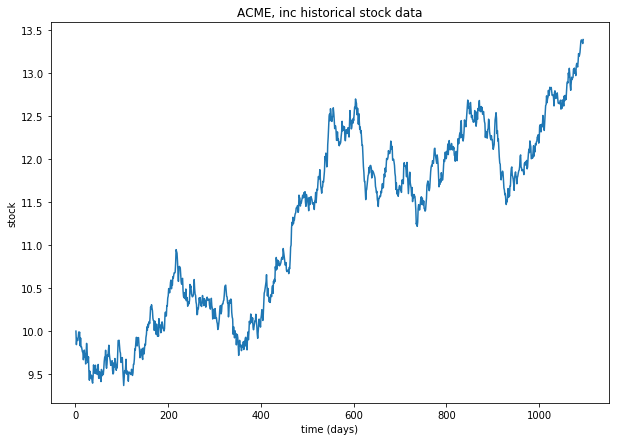

In [9]:
fig = plt.figure(figsize=(10,7))
plt.plot(data[:, 0], data[:, 1])
plt.xlabel("time (days)")
plt.ylabel("stock")
plt.title("ACME, inc historical stock data")
plt.show()

# Find the T (time) and S (stock) from the data and solve for dS/S

In [10]:
T = data[:, 0]
S = data[:, 1]
# Use midpoint estimation (dS_(t+1/2) / S_(t+1/2))
LHS = 2*(S[1:] - S[:-1]) / (S[1:] + S[:-1])
#LHS = (S[1:] - S[:-1]) / S[1:]

# Find the sample estimators for mu and sigma

In [12]:
N = len(T) - 1
mu_hat = np.mean(LHS)
var = (1/(N-1))*np.sum([(xi-mu_hat)**2 for xi in LHS])
sig_hat = np.sqrt(var)
mu_hat, sig_hat

(0.00026697213399613643, 0.006401775859714401)

# Find the MLE estimators for mu and sigma

In [13]:
from scipy.optimize import minimize
# Negative Log-likelihood
NL = lambda Z: N*np.log(np.sqrt(2*np.pi*Z[1]**2)) + (1/(2*Z[1]**2)) * np.linalg.norm(LHS - np.ones(N)*Z[0])**2
p = minimize(NL, (5,5), method='Nelder-Mead')

In [14]:
mu_MLE, sig_MLE = p['x']
p

 final_simplex: (array([[0.00026783, 0.00639917],
       [0.00026706, 0.00639805],
       [0.00026479, 0.00639946]]), array([-3974.17221554, -3974.17221094, -3974.17215479]))
           fun: -3974.172215538165
       message: 'Optimization terminated successfully.'
          nfev: 126
           nit: 66
        status: 0
       success: True
             x: array([0.00026783, 0.00639917])

# Simulate the process using the estimation of mu and sigma

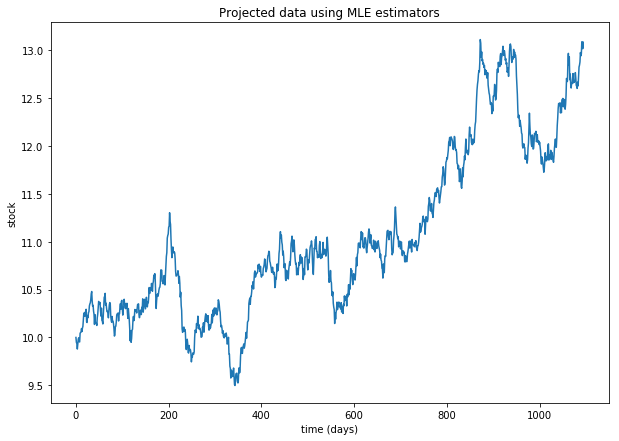

In [26]:
S0_MLE = 10
S_MLE = [S0_MLE]
# Simulate a random rollout using the estimated mu and sigma
for i in range(N):
    dW = np.random.normal(0, 1)
    
    dS_MLE = S0_MLE*mu_MLE + S0_MLE*sig_MLE*dW
    S1_MLE = S0_MLE + dS_MLE
    S_MLE.append(S1_MLE)
    S0_MLE = S1_MLE
    
fig = plt.figure(figsize=(10,7))
plt.plot(S_MLE)
plt.xlabel("time (days)")
plt.ylabel("stock")
plt.title("Projected data using MLE estimators")
plt.show()

# Make prediction

In [27]:
T_final = 1476
# Predict the final value using numerical methods
def euler_maruyama(S0, dt, mu, sig, dW):
    return S0 + mu*S0*dt + sig*S0*dW

def milstein(S0, dt, mu, sig, dW):
    return S0 + mu*S0*dt + sig*S0*dW + (1/2)*sig*(dW**2 - dt)

def numerical_prediction(S0, t_f, dt, mu, sig, method=None):
    if method == "euler_maruyama":
        S = [S0]
        for _ in range(t_f):
            dW = np.random.normal(0, dt)
            S1 = euler_maruyama(S0, dt, mu, sig, dW)
            S.append(S1)
            S0 = S1
        return S
    elif method == "milstein":
        S = [S0]
        for _ in range(t_f):
            dW = np.random.normal(0, dt)
            S1 = milstein(S0, dt, mu, sig, dW)
            S.append(S1)
            S0 = S1
        return S
    else:
        S_e = [S0]
        S_m = [S0]
        for _ in range(t_f):
            dW = np.random.normal(0, dt)
            S_e1 = euler_maruyama(S_e[-1], dt, mu, sig, dW)
            S_m1 = milstein(S_m[-1], dt, mu, sig, dW)
            S_e.append(S_e1)
            S_m.append(S_m1)
        return S_e, S_m

In [37]:
t_f = int(T_final - T[-1])
S0 = S[-1]
dt = 1
S_e, S_m = numerical_prediction(S0, t_f, dt, mu_MLE, sig_MLE, method=None)

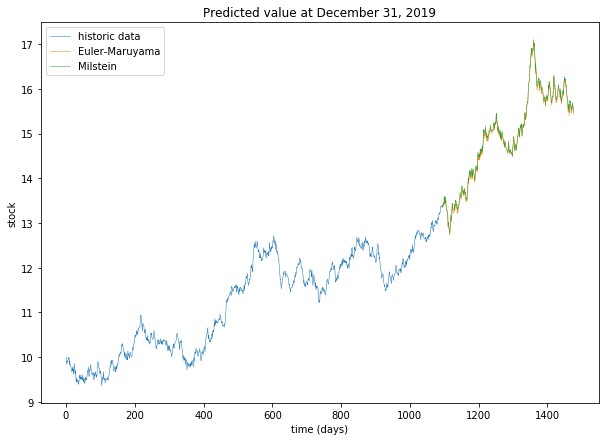

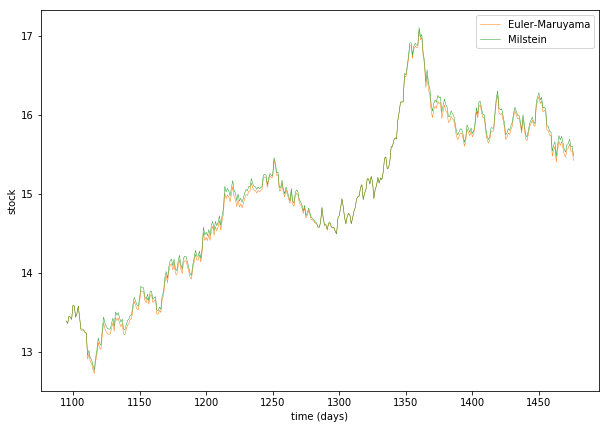

In [38]:
T_ = np.arange(T[-1], T_final+1)
fig = plt.figure(figsize=(10,7))
plt.plot(T, S, linewidth=0.5, label="historic data")
plt.plot(T_, S_e, linewidth=0.5, label="Euler-Maruyama")
plt.plot(T_, S_m, linewidth=0.5, label="Milstein")
plt.xlabel("time (days)")
plt.ylabel("stock")
plt.title("Predicted value at December 31, 2019")
plt.legend()
plt.show()
fig = plt.figure(figsize=(10,7))
plt.plot(T_, S_e, linewidth=0.5, label="Euler-Maruyama", c='C1')
plt.plot(T_, S_m, linewidth=0.5, label="Milstein", c='C2')
plt.xlabel("time (days)")
plt.ylabel("stock")
plt.legend()
plt.show()

# Closed form solution

In [39]:
# Analytic solution at time t
analytic = lambda Z,t,Wt: S0*np.exp((Z[0] - (1/2)*Z[1]**2)*t + Z[1]*Wt)
t = T_final - T[-1]
a_mean = analytic((mu_MLE, sig_MLE), t, 0)
Wt95_l, Wt95_u = -2*np.sqrt(t), 2*np.sqrt(t)
a95_l = analytic((mu_MLE, sig_MLE), t, Wt95_l)
a95_u = analytic((mu_MLE, sig_MLE), t, Wt95_u)

In [40]:
a95_l, a_mean, a95_u

(11.462554156937284, 14.715470815100911, 18.89152089013519)

# Monte-Carlo estimation

In [41]:
mean = []
for _ in range(100000):
    S_out = numerical_prediction(S0, t_f, dt, mu_MLE, sig_MLE, method="milstein")
    mean.append(S_out[-1])

/Users/Seong-EunCho/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/Seong-EunCho/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


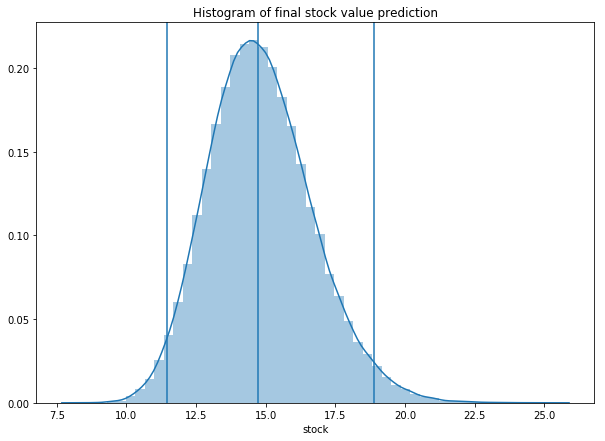

In [45]:
fig = plt.figure(figsize=(10,7))
sbn.distplot(np.array(mean))
plt.axvline(x=a_mean)
plt.axvline(x=a95_l)
plt.axvline(x=a95_u)
plt.xlabel("stock")
plt.title("Histogram of final stock value prediction")
plt.show()

In [212]:
np.mean(mean)

14.828473908960598